In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
SEED = 1234
# same seed generator
torch.manual_seed(SEED)

# to make sure input output are fixed/deterministic
torch.backends.cudnn.deterministic = True

In [10]:
from torchtext import datasets

In [11]:
all_train_data, test_data = datasets.IMDB(split=("train", "test"))

In [12]:
print(f"Number of training examples: {len(all_train_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 25000
Number of testing examples: 25000


In [13]:
all_train_data = [data for data in all_train_data]
test_data = [data for data in test_data]

In [14]:
from torch.utils.data import Dataset, random_split
from spacy.lang.en import English

nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer


class IMDbDataset(Dataset):
    def __init__(self, iterable_dataset):
        datas = [data for data in iterable_dataset]
        self.X = [
            [token.text.lower() for token in tokenizer(data[1])] for data in datas
        ]
        self.y = [data[0] for data in datas]

    # Must have
    def __len__(self):
        return len(self.y)

    # Must have
    def __getitem__(self, index):
        return (self.X[index], self.y[index], index)

In [15]:
all_train_data = IMDbDataset(all_train_data)
test_data = IMDbDataset(test_data)

In [16]:
import random

# split the data into train set and valid set with random seed
train_data, valid_data = random_split(
    all_train_data, [17500, 7500], generator=torch.Generator().manual_seed(SEED)
)
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [17]:
from collections import Counter


class Vocab:
    def __init__(self, tokens, specials=[], max_size=None):
        self.word2idx = {}
        self.idx2word = []
        for special in specials:
            self.insert(special)
        self.freq = Counter(tokens)
        for word, _ in sorted(
            self.freq.items(), key=lambda item: item[1], reverse=True
        ):
            if max_size is not None and len(self.idx2word) >= max_size + 2:
                break
            self.insert(word)

    def insert(self, token):
        if token in self.word2idx.keys():
            return
        self.idx2word.append(token)
        self.word2idx[token] = self.idx2word.index(token)

    def lookup_index(self, word):
        if word not in self.word2idx.keys():
            word = "<unk>"
        return self.word2idx[word]

    def lookup_word(self, idx):
        return self.idx2word[idx]

    def __len__(self):
        return len(self.word2idx)

    def __repr__(self):
        return str(self.word2idx)

In [18]:
# Building Vocabulary
MAX_VOCAB_SIZE = 25000


input_vocab = Vocab(
    tokens=[token for data in train_data for token in data[0]],
    specials=["<pad>", "<unk>"],
    max_size=MAX_VOCAB_SIZE,
)
output_vocab = Vocab(tokens=[data[1] for data in train_data])

print(f"Unique tokens in input vocabulary: {len(input_vocab)}")
print(f"Unique tokens in output vocabulary: {len(output_vocab)}")

# Do not use BucketIterator in your implementation because you are required to implement the padding and masking yourself.
# this is just for verify single instance result
# train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
#     (train_data, valid_data, test_data), batch_size=1, device=device
# )

Unique tokens in input vocabulary: 25002
Unique tokens in output vocabulary: 2


In [19]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [139]:
# label preprocess pipeline
def label_pipeline(label):
    return output_vocab.lookup_index(label)


# text preprocess pipeline
def text_pipeline(text):
    return [input_vocab.lookup_index(str(token)) for token in text]


# preprocess batch data before loading each batch
def collate_batch(batch):
    label_list, text_list, idx_list, len_list = [], [], [], []
    for _text, _label, _index in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        len_list.append(len(processed_text))
        idx_list.append(_index)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    len_list = torch.tensor(len_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return text_list.to(device), label_list.to(device), len_list.to(device), idx_list

In [140]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [141]:
import torch.nn as nn

# define LSTM Classifier model class
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, hidden_dim):
        super().__init__()
        # the word vector for index 0 will be set to zero
        self.embedding = nn.Embedding(
            input_dim, embedding_dim, padding_idx=0
        )
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(
            hidden_dim, output_dim
        )

    def forward(self, text, lens):

        embedded = self.embedding(text)
        embedded = pack_padded_sequence(
            embedded, lens, enforce_sorted=False,
            batch_first= True
        )
        
        out, h_n = self.lstm(embedded)
        out, seq_lengths = pad_packed_sequence(
            out
        )
        
        out = torch.stack(
            [torch.mean(out[: length, i, :], 0) for i, length in enumerate(lens)]
        )
        out = self.fc(out)
        return out

In [142]:
INPUT_DIM = len(input_vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
HIDDEN_DIM = 4
# define the mini-batch size => tunable
batch_size = 1

lstm_model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, HIDDEN_DIM)

In [143]:
# Binary Cross Entropy with sigmoid layer
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [144]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)

    return acc

In [177]:
from tqdm import tqdm


def train(model, optimizer, criterion, dataloader):
    # init epoch loss and accuracy
    epoch_loss = 0
    epoch_acc = 0

    # set to the train mode
    model.train()

    # iterations count for this epoch
    iter_num = 0

    # mini-batch
    data_size = len(dataloader.dataset)
    for X, true_y, lens, _ in tqdm(dataloader, desc="Training...", total=len(dataloader)):

        optimizer.zero_grad()
        
        predictions = model(X, lens)

        loss = criterion(predictions.squeeze(1), true_y.float())

        acc = binary_accuracy(predictions.squeeze(1), true_y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item() * X.shape[0]
        
    return epoch_loss / data_size, epoch_acc / data_size

In [178]:
def evaluate(model, criterion, iterator=None, dataloader=None):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        # mini-batch
        data_size = len(dataloader.dataset)
        for X, true_y, lens, _ in dataloader:

            predictions = model(X, lens)

            loss = criterion(predictions.squeeze(1), true_y.float())

            acc = binary_accuracy(predictions.squeeze(1), true_y)

            epoch_loss += loss.item()
            epoch_acc += acc.item() * X.shape[0]
            
        return epoch_loss / data_size, epoch_acc / data_size

In [179]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [180]:
import torch.optim as optim

def experiment(
    train_data,
    valid_data,
    batch_size=1,
    learning_rate=1e-3,
    num_epoch=1,
    name="experiment_name",
):

    # use data loader for batching data
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=False,
    )
    valid_loader = DataLoader(
        dataset=valid_data,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=False,
    )

    lstm_model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, HIDDEN_DIM)

    # init the optimizer with stochastic gradient descent for each model
    optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)

    # Binary Cross Entropy with sigmoid layer
    criterion = nn.BCEWithLogitsLoss()

    # send modules to the GPU/CPU device
    lstm_model = lstm_model.to(device)
    criterion = criterion.to(device)

    # for recording the training time
    train_time = 0
    best_valid_loss = float("inf")
    best_valid_accu = 0
    for epoch in range(num_epoch):

        start_time = time.time()

        train_loss, train_acc = train(
            lstm_model, optimizer, criterion, dataloader=train_loader
        )

        valid_loss, valid_acc = evaluate(lstm_model, criterion, dataloader=valid_loader)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        train_time += end_time - start_time

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_accu = valid_acc
            torch.save(lstm_model.state_dict(), f"model-lstm-{name}.pt")

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
        print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")
    return lstm_model, train_time, best_valid_accu

In [182]:
experiment(train_data, valid_data, num_epoch=2, name="mb-test")

Training...:   0%|          | 3/17500 [00:00<11:15, 25.90it/s]

Epoch: 01 | Epoch Time: 15m 12s
	Train Loss: 0.694 | Train Acc: 50.75%
	 Val. Loss: 0.693 |  Val. Acc: 52.09%


Training...: 100%|██████████| 17500/17500 [14:37<00:00, 19.94it/s]


Epoch: 02 | Epoch Time: 15m 34s
	Train Loss: 0.693 | Train Acc: 51.78%
	 Val. Loss: 0.693 |  Val. Acc: 53.12%


(LSTMClassifier(
   (embedding): Embedding(25002, 100, padding_idx=0)
   (lstm): LSTM(100, 4)
   (fc): Linear(in_features=4, out_features=1, bias=True)
 ),
 1847.4969103336334,
 0.5312)

In [183]:
lstm_model.load_state_dict(torch.load('model-lstm-mb-test.pt'))

test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    collate_fn=collate_batch,
    shuffle=False,
)

# Binary Cross Entropy with sigmoid layer
criterion = nn.BCEWithLogitsLoss()

test_loss, test_acc = evaluate(lstm_model, criterion, dataloader=test_loader)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.001 | Test Acc: 53.67%


In [184]:
batch_sizes = [32, 64, 128, 256, 512]
train_times, valid_accus, models = [], [], []
for batch_size in batch_sizes:
    model, train_time, best_valid_accu = experiment(
        train_data,
        valid_data,
        batch_size=batch_size,
        num_epoch=5,
        name=f"batch-{batch_size}",
    )
    train_times.append(train_time)
    valid_accus.append(best_valid_accu)
    models.append(model)

Training...:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 22s
	Train Loss: 0.022 | Train Acc: 49.89%
	 Val. Loss: 0.022 |  Val. Acc: 50.13%


Training...:   0%|          | 1/547 [00:00<00:55,  9.85it/s]

Epoch: 02 | Epoch Time: 2m 21s
	Train Loss: 0.022 | Train Acc: 49.89%
	 Val. Loss: 0.022 |  Val. Acc: 50.03%


Training...:   0%|          | 1/547 [00:00<01:10,  7.76it/s]

Epoch: 03 | Epoch Time: 2m 23s
	Train Loss: 0.022 | Train Acc: 49.86%
	 Val. Loss: 0.022 |  Val. Acc: 50.13%


Training...:   0%|          | 1/547 [00:00<00:56,  9.74it/s]

Epoch: 04 | Epoch Time: 2m 25s
	Train Loss: 0.022 | Train Acc: 49.85%
	 Val. Loss: 0.022 |  Val. Acc: 50.07%


Training...:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 2m 24s
	Train Loss: 0.022 | Train Acc: 49.62%
	 Val. Loss: 0.022 |  Val. Acc: 50.00%


Training...:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 42s
	Train Loss: 0.011 | Train Acc: 49.90%
	 Val. Loss: 0.011 |  Val. Acc: 50.23%


Training...:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 39s
	Train Loss: 0.011 | Train Acc: 49.90%
	 Val. Loss: 0.011 |  Val. Acc: 50.23%


Training...:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 44s
	Train Loss: 0.011 | Train Acc: 49.90%
	 Val. Loss: 0.011 |  Val. Acc: 50.23%


Training...:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 40s
	Train Loss: 0.011 | Train Acc: 49.90%
	 Val. Loss: 0.011 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 2m 7s
	Train Loss: 0.011 | Train Acc: 49.90%
	 Val. Loss: 0.011 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 45s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 40s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 28s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 24s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 28s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 24s
	Train Loss: 0.003 | Train Acc: 49.90%
	 Val. Loss: 0.003 |  Val. Acc: 50.23%


Training...:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 2m 18s
	Train Loss: 0.003 | Train Acc: 49.90%
	 Val. Loss: 0.003 |  Val. Acc: 50.23%


Training...:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 2m 25s
	Train Loss: 0.003 | Train Acc: 49.90%
	 Val. Loss: 0.003 |  Val. Acc: 50.23%


Training...:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 2m 26s
	Train Loss: 0.003 | Train Acc: 49.90%
	 Val. Loss: 0.003 |  Val. Acc: 50.23%


Training...:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 2m 25s
	Train Loss: 0.003 | Train Acc: 49.90%
	 Val. Loss: 0.003 |  Val. Acc: 50.23%


Training...:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 3m 26s
	Train Loss: 0.001 | Train Acc: 50.10%
	 Val. Loss: 0.001 |  Val. Acc: 49.77%


Training...:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 3m 25s
	Train Loss: 0.001 | Train Acc: 50.10%
	 Val. Loss: 0.001 |  Val. Acc: 49.77%


Training...:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 3m 25s
	Train Loss: 0.001 | Train Acc: 50.10%
	 Val. Loss: 0.001 |  Val. Acc: 49.77%


Training...:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 3m 25s
	Train Loss: 0.001 | Train Acc: 50.10%
	 Val. Loss: 0.001 |  Val. Acc: 49.77%


Training...: 100%|██████████| 35/35 [03:22<00:00,  5.79s/it]


Epoch: 05 | Epoch Time: 3m 26s
	Train Loss: 0.001 | Train Acc: 50.10%
	 Val. Loss: 0.001 |  Val. Acc: 49.77%


In [185]:
from sklearn import preprocessing

normalized_times = preprocessing.normalize([train_times])[0]
normalized_accus = preprocessing.normalize([valid_accus])[0]

In [186]:
time_accu_ratio = [
    time / normalized_accus[i] for i, time in enumerate(normalized_times)
]
best_batch_idx = time_accu_ratio.index(min(time_accu_ratio))
best_batch_size = batch_sizes[best_batch_idx]

In [187]:
train_times, valid_accus, time_accu_ratio

([718.4843471050262,
  534.4424893856049,
  467.1400079727173,
  720.7049136161804,
  1029.92040848732],
 [0.5,
  0.5022666666666666,
  0.4977333335240682,
  0.5022666667779286,
  0.4977333339055379],
 [0.9963245720428082,
  0.7377685807424146,
  0.6507345590236747,
  0.9948936540321985,
  1.434697929730667])

In [189]:
import numpy as np
learning_rates = np.logspace(-5, -1, num=5)
lr_tuning_valid_accus, lr_tuning_models = [], []
for lr in learning_rates:
    model, _, best_valid_accu = experiment(
        train_data,
        valid_data,
        learning_rate=lr,
        batch_size=best_batch_size,
        num_epoch=5,
        name=f"lr-{lr}",
    )
    lr_tuning_valid_accus.append(best_valid_accu)
    lr_tuning_models.append(model)

Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 24s
	Train Loss: 0.006 | Train Acc: 49.90%
	 Val. Loss: 0.006 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 26s
	Train Loss: 0.006 | Train Acc: 49.90%
	 Val. Loss: 0.006 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 23s
	Train Loss: 0.006 | Train Acc: 49.90%
	 Val. Loss: 0.006 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 24s
	Train Loss: 0.006 | Train Acc: 49.90%
	 Val. Loss: 0.006 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 23s
	Train Loss: 0.006 | Train Acc: 49.90%
	 Val. Loss: 0.006 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 24s
	Train Loss: 0.005 | Train Acc: 50.07%
	 Val. Loss: 0.005 |  Val. Acc: 49.84%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 24s
	Train Loss: 0.005 | Train Acc: 50.07%
	 Val. Loss: 0.005 |  Val. Acc: 49.84%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 0.005 | Train Acc: 50.07%
	 Val. Loss: 0.005 |  Val. Acc: 49.87%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 25s
	Train Loss: 0.005 | Train Acc: 50.08%
	 Val. Loss: 0.005 |  Val. Acc: 49.87%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 27s
	Train Loss: 0.005 | Train Acc: 50.08%
	 Val. Loss: 0.005 |  Val. Acc: 49.87%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 26s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 26s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.77%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 24s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.79%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 49.79%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 26s
	Train Loss: 0.005 | Train Acc: 49.90%
	 Val. Loss: 0.005 |  Val. Acc: 50.23%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 26s
	Train Loss: 0.005 | Train Acc: 49.91%
	 Val. Loss: 0.005 |  Val. Acc: 50.24%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 27s
	Train Loss: 0.005 | Train Acc: 49.95%
	 Val. Loss: 0.005 |  Val. Acc: 50.19%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 25s
	Train Loss: 0.005 | Train Acc: 50.10%
	 Val. Loss: 0.005 |  Val. Acc: 50.37%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.005 | Train Acc: 50.25%
	 Val. Loss: 0.005 |  Val. Acc: 51.12%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 26s
	Train Loss: 0.005 | Train Acc: 50.97%
	 Val. Loss: 0.005 |  Val. Acc: 51.67%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 26s
	Train Loss: 0.005 | Train Acc: 52.60%
	 Val. Loss: 0.005 |  Val. Acc: 52.92%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 28s
	Train Loss: 0.005 | Train Acc: 53.25%
	 Val. Loss: 0.005 |  Val. Acc: 53.75%


Training...:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 39s
	Train Loss: 0.005 | Train Acc: 54.09%
	 Val. Loss: 0.005 |  Val. Acc: 54.23%


Training...: 100%|██████████| 137/137 [01:32<00:00,  1.48it/s]


Epoch: 05 | Epoch Time: 1m 38s
	Train Loss: 0.005 | Train Acc: 54.79%
	 Val. Loss: 0.005 |  Val. Acc: 54.79%


In [190]:
lr_tuning_valid_accus

[0.5022666667779286,
 0.4986666668574015,
 0.49786666685740155,
 0.5112000001907349,
 0.5478666664441426]

In [191]:
best_lr_idx = lr_tuning_valid_accus.index(max(lr_tuning_valid_accus))
best_lr = learning_rates[best_lr_idx]

<ipython-input-192-7eede5d10490>:7: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  time_vs_batch_ax.set_xscale("log", basex=2)
<ipython-input-192-7eede5d10490>:14: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  accu_vs_batch_ax.set_xscale("log", basex=2)


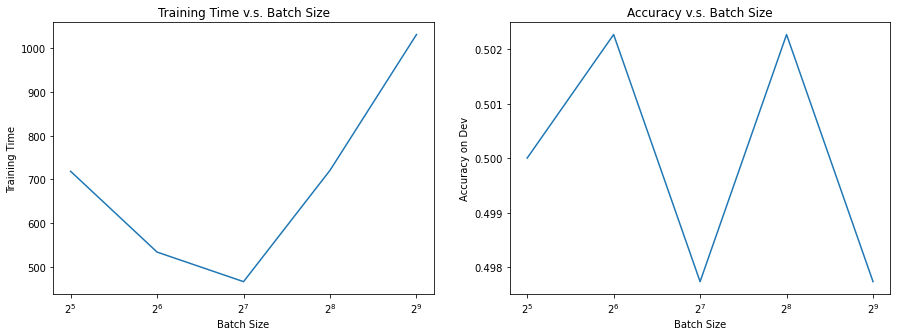

In [192]:
from matplotlib import pyplot as plt

batch_fig, axes = plt.subplots(1, 2, figsize=(15, 5))
time_vs_batch_ax, accu_vs_batch_ax = axes[0], axes[1]

# Plot the comparison between training time and batch size
time_vs_batch_ax.set_xscale("log", basex=2)
time_vs_batch_ax.set_xlabel("Batch Size")
time_vs_batch_ax.set_ylabel("Training Time")
time_vs_batch_ax.set_title("Training Time v.s. Batch Size")
time_vs_batch_ax.plot(batch_sizes, train_times)

# Plot the comparison between Dev set accuracy and batch size
accu_vs_batch_ax.set_xscale("log", basex=2)
accu_vs_batch_ax.set_xlabel("Batch Size")
accu_vs_batch_ax.set_ylabel("Accuracy on Dev")
accu_vs_batch_ax.set_title("Accuracy v.s. Batch Size")
accu_vs_batch_ax.plot(batch_sizes, valid_accus)

batch_fig.savefig("lstm_batch_fig.jpg")

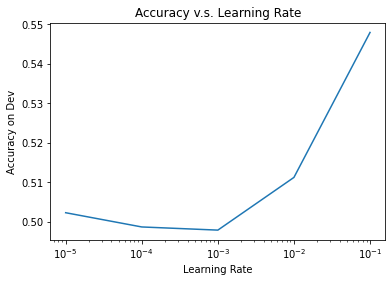

In [193]:
# Plot the comparison between Dev set accuracy and learning rate
lr_fig, accu_vs_lr_ax = plt.subplots()
accu_vs_lr_ax.set_xscale("log")
accu_vs_lr_ax.set_xlabel("Learning Rate")
accu_vs_lr_ax.set_ylabel("Accuracy on Dev")
accu_vs_lr_ax.set_title("Accuracy v.s. Learning Rate")
accu_vs_lr_ax.plot(learning_rates, lr_tuning_valid_accus)

lr_fig.savefig("lstm_lr_fig.jpg")

In [194]:
# Traing on all training data
model, _, best_valid_accu = experiment(
    all_train_data,
    all_train_data,
    learning_rate=best_lr,
    batch_size=best_batch_size,
    num_epoch=5,
    name=f"best",
)

Training...:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 23s
	Train Loss: 0.003 | Train Acc: 84.30%
	 Val. Loss: 0.008 |  Val. Acc: 50.00%


Training...:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 2m 28s
	Train Loss: 0.004 | Train Acc: 72.85%
	 Val. Loss: 0.008 |  Val. Acc: 50.00%


Training...:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 2m 20s
	Train Loss: 0.004 | Train Acc: 72.54%
	 Val. Loss: 0.008 |  Val. Acc: 50.00%


Training...:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 2m 41s
	Train Loss: 0.004 | Train Acc: 72.54%
	 Val. Loss: 0.008 |  Val. Acc: 50.00%


Training...: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]


Epoch: 05 | Epoch Time: 2m 44s
	Train Loss: 0.004 | Train Acc: 72.54%
	 Val. Loss: 0.008 |  Val. Acc: 50.00%


In [196]:
# load the best model and evaluate the test set
model.load_state_dict(torch.load("model-lstm-best.pt"))

test_loader = DataLoader(
    dataset=test_data, batch_size=best_batch_size, collate_fn=collate_batch, shuffle=False
)
test_loss, test_acc = evaluate(model, criterion, dataloader=test_loader)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.008 | Test Acc: 50.00%


In [197]:
# for mapping indexes to seq/labels
def idx2word_seq(raw_indexes, dataset):
    batch_seq = []
    for idx in raw_indexes:
        batch_seq.append(" ".join(dataset.X[idx]))
    return batch_seq


def idx2labels(indexes):
    batch_seq = []
    for idx in indexes:
        batch_seq.append(output_vocab.lookup_word(idx))
    return batch_seq

In [198]:

valid_loader = DataLoader(
    dataset=valid_data,
    batch_size=best_batch_size,
    collate_fn=collate_batch,
    shuffle=False,
)

In [199]:
# generate output for val set and test set with the best model
valid_text, valid_label, valid_correct = [], [], []
test_text, test_label, test_correct = [], [], []
for X, y, lens, idx in tqdm(valid_loader):
    predictions = model(X, lens)
    rounded_preds = torch.round(torch.sigmoid(predictions.squeeze(1)))
    correct = rounded_preds == y.T
    valid_text += idx2word_seq(idx, test_data)
    valid_label += idx2labels(rounded_preds.int().squeeze().cpu().detach().numpy())
    valid_correct += [c.item() for c in correct]
    
for X, y, lens, idx in tqdm(test_loader):
    predictions = model(X, lens)
    rounded_preds = torch.round(torch.sigmoid(predictions.squeeze(1)))
    correct = rounded_preds == y.T
    test_text += idx2word_seq(idx, test_data)
    test_label += idx2labels(rounded_preds.int().squeeze().cpu().detach().numpy())
    test_correct += [c.item() for c in correct]

100%|██████████| 196/196 [00:26<00:00,  7.44it/s]


In [200]:
import pandas as pd

# output the prediction results as csv files

lr_dev_pred_df = pd.DataFrame(data={
    "text": valid_text,
    "label": valid_label,
    "correctness": valid_correct
})

lr_test_pred_df = pd.DataFrame(data={
    "text": test_text,
    "label": test_label,
    "correctness": test_correct
})
lr_dev_pred_df.to_csv("lstm_dev_output.csv", index=False)
lr_test_pred_df.to_csv("lstm_test_output.csv", index=False)